In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras, config
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from sklearn.metrics import classification_report

In [2]:
def TrainData():
    fake_img = r"archive\train\FAKE"
    real_img = r"archive\train\REAL"
    train_img = []
    train_label = []

    random_fake = np.random.choice(os.listdir(fake_img), 25000, replace=False)
    random_real = np.random.choice(os.listdir(real_img), 25000, replace=False)

    for p in tqdm(random_fake, desc='Fake Training Data from CIFAKE'):
        train_img.append(os.path.join(fake_img, p))
        train_label.append('AI')
    for p in tqdm(random_real, desc='Real Training Data'):
        train_img.append(os.path.join(real_img, p))
        train_label.append('Real')
    
    print(f'{len(train_label)} training images loaded.')
    train_img = pd.Series(train_img, name="path")
    train_label = pd.Series(train_label, name="labels")
    train_data = pd.concat([train_img, train_label], axis=1)
    
    return train_data

In [3]:
def TestData():
    fake_img = r"archive\test\FAKE"
    real_img = r"archive\test\REAL"
    test_img = []
    test_label = []

    for p in tqdm(os.listdir(fake_img), desc='Fake Testing Data'):
        test_img.append(os.path.join(fake_img, p))
        test_label.append('AI')
    for p in tqdm(os.listdir(real_img), desc='Real Testing Data'):
        test_img.append(os.path.join(real_img, p))
        test_label.append('Real')
    
    test_img = pd.Series(test_img, name="path")
    test_label = pd.Series(test_label, name="labels")
    test_data = pd.concat([test_img, test_label], axis=1)
    print('25000 testing images loaded.')
    
    return test_data

In [4]:
def ImageGen(train_data, test_data):
    gen1 = ImageDataGenerator(
        # rescale=1/255,
        rotation_range=45,
        horizontal_flip=True,
        vertical_flip=True,
    )

    gen2 = ImageDataGenerator(
        # rescale=1/255,
    )

    train_gen = gen1.flow_from_dataframe(
        train_data, 
        x_col='path', 
        y_col='labels', 
        target_size=(32, 32), 
        class_mode= 'categorical', 
        color_mode='rgb', 
        shuffle=True, 
        batch_size=200
    )

    test_gen = gen2.flow_from_dataframe(
        test_data,
        x_col='path', 
        y_col='labels', 
        target_size=(32, 32), 
        class_mode= 'categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=200
    )

    return train_gen, test_gen

In [5]:
def Built_Model():
    base_model = keras.applications.EfficientNetV2B3(
        include_top=False, 
        weights="imagenet", 
        input_shape=(32, 32, 3), 
        pooling='max'
    )
    base_model.trainable = True

    x = base_model.output
    x = BatchNormalization()(x)
    x = Dense(
        256,
        kernel_regularizer = keras.regularizers.l2(l=0.015), 
        activity_regularizer = keras.regularizers.l1(0.006), 
        bias_regularizer = keras.regularizers.l1(0.006), 
        activation='relu'
    )(x)
    x = Dropout(rate=0.4, seed=123)(x) 

    output = Dense(2, activation='softmax')(x)

    model = keras.models.Model(inputs=base_model.input, outputs=output)

    model.compile(keras.optimizers.Adamax(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [6]:
train_data = TrainData()
test_data = TestData()

Real Training Data: 100%|██████████| 25000/25000 [00:00<00:00, 437573.97it/s]


50000 training images loaded.


Real Testing Data: 100%|██████████| 10000/10000 [00:00<00:00, 548303.70it/s]

25000 testing images loaded.


In [7]:
"""
Tensorflow supports running computations on GPU 

WARNING : You need to have CUDA, cuDNN, and tensorflow with version lower than 2.11.0, 
          if not, DON'T execute this cell.
"""
physical_devices = config.list_physical_devices('GPU')
config.experimental.set_memory_growth(physical_devices[0], True)
print('Running on GPU available now')

Running on GPU available now


In [8]:
train_data, test_data = ImageGen(train_data, test_data)

Found 50000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [9]:
model = Built_Model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 16, 16, 40)   1080        ['normalization[0][0]']          
                                                                                              

In [10]:
history = model.fit(train_data, steps_per_epoch=len(train_data), epochs=20, validation_data=test_data)

Epoch 1/20
250/250 [==============================] - 423s 2s/step - loss: 3.4435 - accuracy: 0.7919 - val_loss: 1.6073 - val_accuracy: 0.8760
Epoch 2/20
250/250 [==============================] - 36s 145ms/step - loss: 1.0238 - accuracy: 0.9001 - val_loss: 0.6744 - val_accuracy: 0.8851
Epoch 3/20
250/250 [==============================] - 35s 141ms/step - loss: 0.4668 - accuracy: 0.9185 - val_loss: 0.4414 - val_accuracy: 0.8751
Epoch 4/20
250/250 [==============================] - 36s 144ms/step - loss: 0.2944 - accuracy: 0.9324 - val_loss: 0.3484 - val_accuracy: 0.8870
Epoch 5/20
250/250 [==============================] - 36s 143ms/step - loss: 0.2377 - accuracy: 0.9394 - val_loss: 0.3046 - val_accuracy: 0.8989
Epoch 6/20
250/250 [==============================] - 36s 144ms/step - loss: 0.2133 - accuracy: 0.9446 - val_loss: 0.2603 - val_accuracy: 0.9125
Epoch 7/20
250/250 [==============================] - 36s 143ms/step - loss: 0.1943 - accuracy: 0.9493 - val_loss: 0.2604 - val_accu

In [11]:
pred = model.predict(test_data)
predicted = [(np.argmax(i)) for i in pred]

100/100 [==============================] - 7s 56ms/step


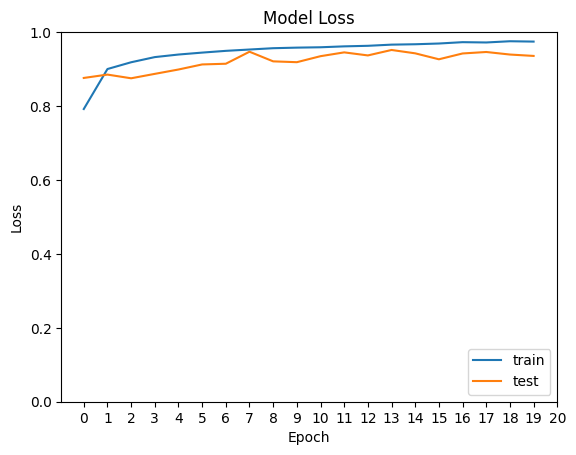

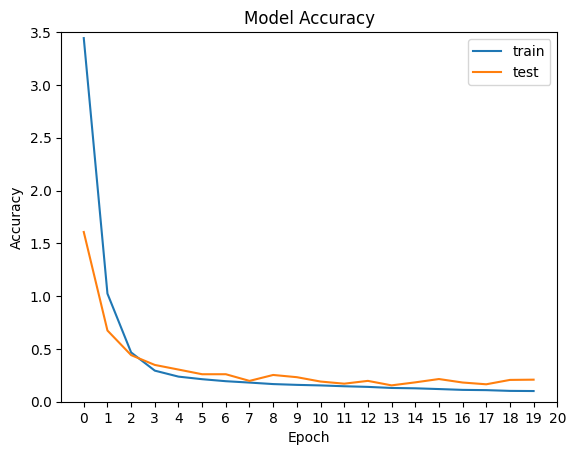

In [15]:
# Plot the loss and accuracy of training set.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks(range(0, 21, 1))
plt.ylim(0, 1)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(range(0, 21, 1))
plt.ylim(0, 3.5)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
print('\nClassification Report:\n----------------------\n', classification_report(np.array(test_data.labels), predicted))


Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     10000
           1       0.99      0.88      0.93     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



In [14]:
# Model saved
model.save('Models/EfficientNet.h5')